# Multi-GCGRU with american data

## Install Dependencies

In [58]:
!pip install tensorflow numpy pandas matplotlib scikit-learn yfinance

In [59]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [60]:
CSV_EDGES     = "data/assets/business_relationship_graph.csv"
CSV_INDUSTRY  = "data/assets/american_industry.csv"
CSV_HOLDERS   = "data/assets/yahoo_finance_shareholders.csv"

USE_GCN_NORM  = True          # normalisation Â = D⁻¹ᐟ²(A+I)D⁻¹ᐟ² ?
Units_GCN     = [16, 32]      # tailles des couches GCN
Units_GRU     = [16, 32]      # tailles des couches GRU
Units_FC      = [1]           # taille de la couche fully‑connected
Matrix_Weights = [1, 1, 1]    # pondérations des graphes
Is_Dyn        = False         # « graphe fixe » (comme le papier)
M_SAMPLES     = 1000          # démo
P_STEPS       = 10
F_FEAT        = 8

EPOCHS        = 10            # démo
BATCH_SIZE    = 32
SEED          = 5


# Section 1 : Data preprocess

In [61]:
edges   = pd.read_csv(CSV_EDGES)
meta    = pd.read_csv(CSV_INDUSTRY)
holders = pd.read_csv(CSV_HOLDERS)

tickers = sorted(set(edges['Source']) | set(edges['Target']) |
                 set(meta['symbol'])  | set(holders['Ticker']))
idx = {t:i for i,t in enumerate(tickers)}
N  = len(tickers)

# -- T : relations business --------------------------------------------------------
T = np.zeros((N, N), dtype=np.float32)
for _, r in edges.iterrows():
    i, j = idx[r['Source']], idx[r['Target']]
    T[i, j] = T[j, i] = 1.0

# -- I : même secteur -------------------------------------------------------------
sector = meta.set_index('symbol')['sector']
sec_vec = sector.reindex(tickers)
I = (sec_vec.values[:, None] == sec_vec.values[None, :]).astype(np.float32)

# -- S : actionnaires communs ------------------------------------------------------
share_sets = holders.groupby('Ticker')['Stockholder'].apply(set).to_dict()
S = np.zeros((N, N), dtype=np.float32)
for i, ti in enumerate(tickers):
    for j in range(i, N):
        common = share_sets.get(ti,set()) & share_sets.get(j,set())
        if common:
            w = len(common)
            S[i,j] = S[j,i] = w

print("Shapes -> T",T.shape,"I",I.shape,"S",S.shape)

Shapes -> T (50, 50) I (50, 50) S (50, 50)


In [62]:
def gcn_norm(A):
    A = A + np.eye(A.shape[0], dtype=np.float32)
    d = A.sum(1)
    d_inv = np.power(d, -0.5, where=d>0)
    D = np.diag(d_inv)
    return D @ A @ D

Fixed_Matrices = [
    tf.constant(gcn_norm(S) if USE_GCN_NORM else S, dtype=tf.float32),
    tf.constant(gcn_norm(I) if USE_GCN_NORM else I, dtype=tf.float32),
    tf.constant(gcn_norm(T) if USE_GCN_NORM else T, dtype=tf.float32),
]

rng = np.random.default_rng(SEED)
samples = rng.normal(size=(M_SAMPLES, P_STEPS, N, F_FEAT)).astype(np.float32)
labels  = rng.binomial(1, 0.5, size=(M_SAMPLES, N)).astype(np.float32)  # cible binaire

x_tr, x_tmp, y_tr, y_tmp = train_test_split(samples, labels,
                                            test_size=0.30, random_state=SEED)
x_val, x_te, y_val, y_te = train_test_split(x_tmp, y_tmp,
                                            test_size=0.33, random_state=SEED)

# numpy → tensors
x_tr  = tf.constant(x_tr);   y_tr  = tf.constant(y_tr)
x_val = tf.constant(x_val);  y_val = tf.constant(y_val)
x_te  = tf.constant(x_te);   y_te  = tf.constant(y_te)

# Section 2 : Multi-GCGRU

In [63]:
class GCGRU(tf.keras.Model):
    def __init__(self, N, F, Units_GCN, Units_GRU, Units_FC,
                 Fixed_Matrices, Matrix_Weights, Is_Dyn,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super().__init__()
        self.N = N; self.F = F; self.mat = Fixed_Matrices
        self.dyn = self.add_weight(name='w_Dynamic', shape=(N,N),
                                   initializer=kernel_initializer, trainable=True)
        if Is_Dyn:
            self.mats = self.dyn
        else:
            self.mats = self.add_weight(name='w_Matrices', shape=(N,N),
                                        initializer=kernel_initializer, trainable=True)
            for i in range(len(Matrix_Weights)):
                coe = tf.Variable(1.0, trainable=True)
                self.mats = self.mats + Matrix_Weights[i]*self.mat[i]*coe
        # ---------- GCN ----------
        self.units_gcn, self.w_gcn, self.b_gcn = Units_GCN, [], []
        pre = F
        for u in Units_GCN:
            self.w_gcn.append(self.add_weight(shape=(pre,u),
                             initializer=kernel_initializer, trainable=True))
            self.b_gcn.append(self.add_weight(shape=(u,),
                             initializer=bias_initializer, trainable=True))
            pre = u
        # ---------- GRU ----------
        self.units_gru, self.w_gru, self.b_gru = Units_GRU, [], []
        C, Fcurr = Units_GCN[-1], F
        for H in Units_GRU[:-1]:
            pre = Fcurr + C + H
            for _ in range(3):                      # z, r, h~
                self.w_gru.append(self.add_weight(shape=(pre,H),
                                   initializer=kernel_initializer, trainable=True))
                self.b_gru.append(self.add_weight(shape=(H,),
                                   initializer=bias_initializer, trainable=True))
            Fcurr = H
        # dernière projection GRU
        H_last, G = Units_GRU[-2], Units_GRU[-1]
        self.w_gru.append(self.add_weight(shape=(H_last,G),
                           initializer=kernel_initializer, trainable=True))
        self.b_gru.append(self.add_weight(shape=(G,),
                           initializer=bias_initializer, trainable=True))
        # ---------- FC ----------
        self.units_fc, self.w_fc, self.b_fc = Units_FC, [], []
        pre = G
        for u in Units_FC:
            self.w_fc.append(self.add_weight(shape=(pre,u),
                             initializer=kernel_initializer, trainable=True))
            self.b_fc.append(self.add_weight(shape=(u,),
                             initializer=bias_initializer, trainable=True))
            pre = u

    # ------ sous‑blocs ------
    def Multi_GCN(self, x):
        P = x.shape[1]; out = []
        for t in range(P):
            h = x[:,t,:,:]                         # (batch,N,F)
            for l in range(len(self.units_gcn)):
                h = tf.tanh(self.mats @ h @ self.w_gcn[l] + self.b_gcn[l])
            out.append(h)
        return tf.stack(out, axis=1)               # (batch,P,N,C)

    def GRU(self, x, x_gcn):
        h_gru = [ tf.zeros_like(x[:,0,:,:]) @ tf.zeros([self.F,self.units_gru[i]])
                  for i in range(len(self.units_gru)-1) ]
        for t in range(x.shape[1]):
            xt, xt_gcn = x[:,t,:,:], x_gcn[:,t,:,:]
            for i,H in enumerate(self.units_gru[:-1]):
                h_prev = h_gru[i]
                concat = tf.concat([xt, xt_gcn, h_prev], axis=2)
                z = tf.sigmoid(concat @ self.w_gru[3*i+0] + self.b_gru[3*i+0])
                r = tf.sigmoid(concat @ self.w_gru[3*i+1] + self.b_gru[3*i+1])
                h_hat = tf.tanh(tf.concat([xt, xt_gcn, r*h_prev], axis=2)
                                @ self.w_gru[3*i+2] + self.b_gru[3*i+2])
                h = z*h_prev + (1-z)*h_hat
                h_gru[i] = xt = h
        x_gru = tf.sigmoid(h @ self.w_gru[-1] + self.b_gru[-1])  # (batch,N,G)
        return x_gru

    def FC(self, x):
        for l in range(len(self.w_fc)):
            x = tf.sigmoid(x @ self.w_fc[l] + self.b_fc[l])
        return tf.squeeze(x, axis=-1)              # (batch,N)

    # ------ appel complet ------
    def call(self, x):
        x_gcn = self.Multi_GCN(x)
        x_gru = self.GRU(x, x_gcn)
        return self.FC(x_gru)

# Section 3 : Build the model

In [64]:
# instanciation
model = GCGRU(N, F_FEAT, Units_GCN, Units_GRU, Units_FC,
              Fixed_Matrices, Matrix_Weights, Is_Dyn)
model.build((None, P_STEPS, N, F_FEAT))
model.summary()

Model: "gcgru_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,001 (35.16 KB)

 Trainable params: 9,001 (35.16 KB)

 Non-trainable params: 0 (0.00 B)

# Section 4 : Train the model

Epoch 1/10


/Users/tristanlachance/.julia/conda/3/aarch64/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['gcgru_6/w_Dynamic', 'gcgru_6/w_Matrices'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


22/22 - 3s - 132ms/step - binary_accuracy: 0.4928 - loss: 0.6966 - val_binary_accuracy: 0.5103 - val_loss: 0.6935
Epoch 2/10
22/22 - 0s - 15ms/step - binary_accuracy: 0.5032 - loss: 0.6937 - val_binary_accuracy: 0.5089 - val_loss: 0.6931
Epoch 3/10
22/22 - 0s - 14ms/step - binary_accuracy: 0.5075 - loss: 0.6932 - val_binary_accuracy: 0.5066 - val_loss: 0.6930
Epoch 4/10
22/22 - 0s - 14ms/step - binary_accuracy: 0.5120 - loss: 0.6929 - val_binary_accuracy: 0.5041 - val_loss: 0.6931
Epoch 5/10
22/22 - 0s - 18ms/step - binary_accuracy: 0.5164 - loss: 0.6927 - val_binary_accuracy: 0.5087 - val_loss: 0.6931
Epoch 6/10
22/22 - 0s - 21ms/step - binary_accuracy: 0.5169 - loss: 0.6925 - val_binary_accuracy: 0.5015 - val_loss: 0.6933
Epoch 7/10
22/22 - 0s - 22ms/step - binary_accuracy: 0.5175 - loss: 0.6923 - val_binary_accuracy: 0.5016 - val_loss: 0.6933
Epoch 8/10
22/22 - 1s - 24ms/step - binary_accuracy: 0.5217 - loss: 0.6920 - val_binary_accuracy: 0.5004 - val_loss: 0.6934
Epoch 9/10
22/22 -

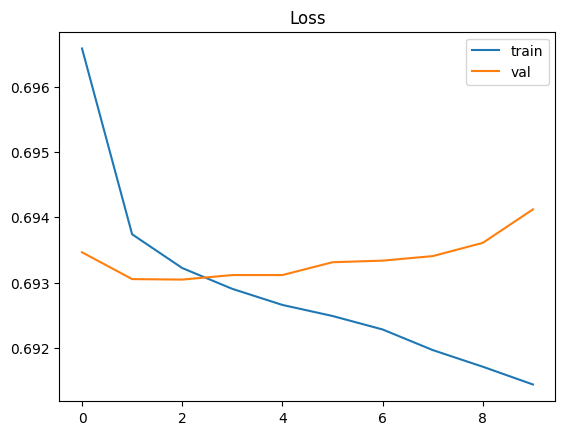

Test metrics : [0.6937881708145142, 0.508888840675354]


In [65]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(x_tr, y_tr,
                    validation_data=(x_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2)

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend(); plt.title("Loss"); plt.show()

print("Test metrics :", model.evaluate(x_te, y_te, verbose=0))